In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

import random
import os
import warnings
warnings.filterwarnings('ignore')


Data importing  & Visualization

In [3]:
train_dir = r'C:\Users\Farid Pashayev\Desktop\UFAZ\Master Project\Plant Diseases Detection\dataset\plant_leaf_dataset\train'
valid_dir = r'C:\Users\Farid Pashayev\Desktop\UFAZ\Master Project\Plant Diseases Detection\dataset\plant_leaf_dataset\valid'

In [4]:
# apply scaling only becouse data already augmented
train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

In [5]:
print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=64,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

Training Images:
Found 48758 images belonging to 33 classes.


In [6]:
# load validation data (20% of training data)
print("Validating Images:")
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=64,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Validating Images:
Found 12172 images belonging to 33 classes.


In [7]:
# load test data (consider validation data as test data)
print('Test Images:')
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=(224, 224),
                                               batch_size=64,
                                               class_mode='categorical',
                                               shuffle=False)

Test Images:
Found 15231 images belonging to 33 classes.


In [8]:
# show how data store
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


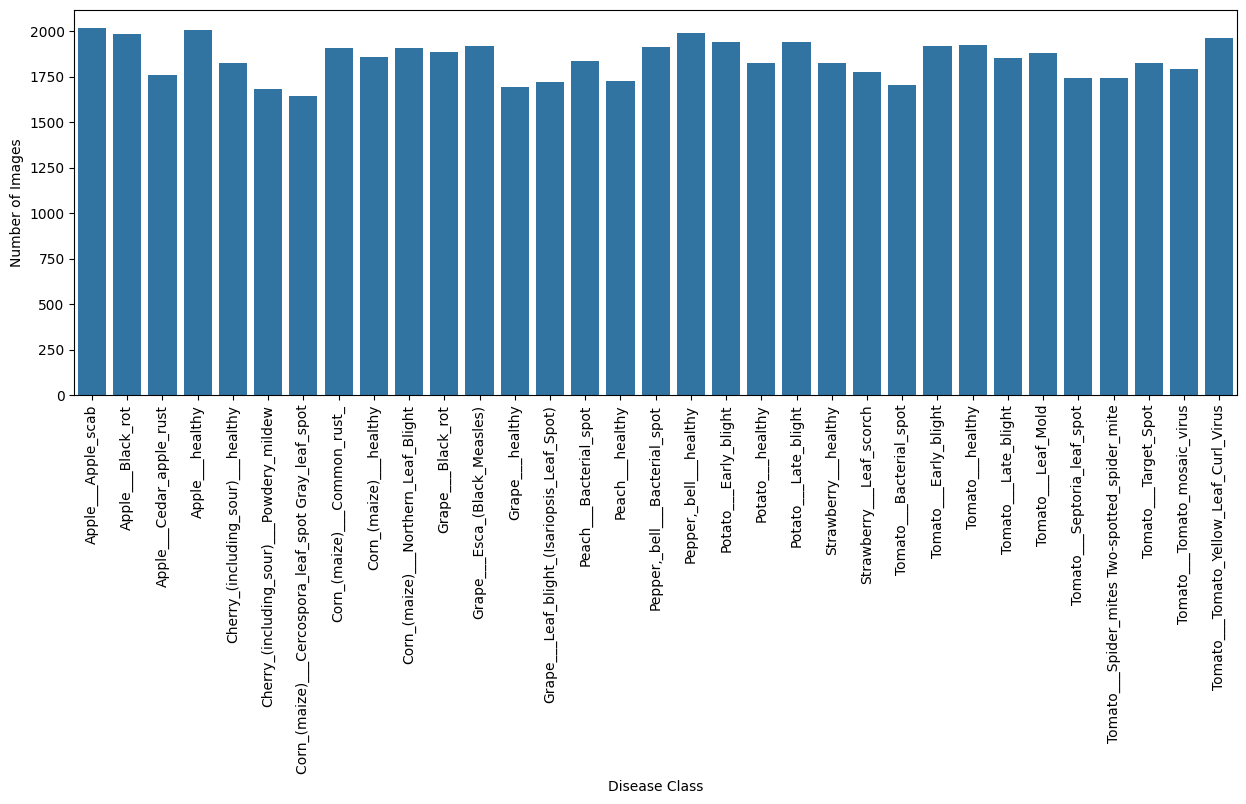

In [24]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

# df = df.sort_values(by="Number of Images", ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

As we notice that classes are somewhat balanced

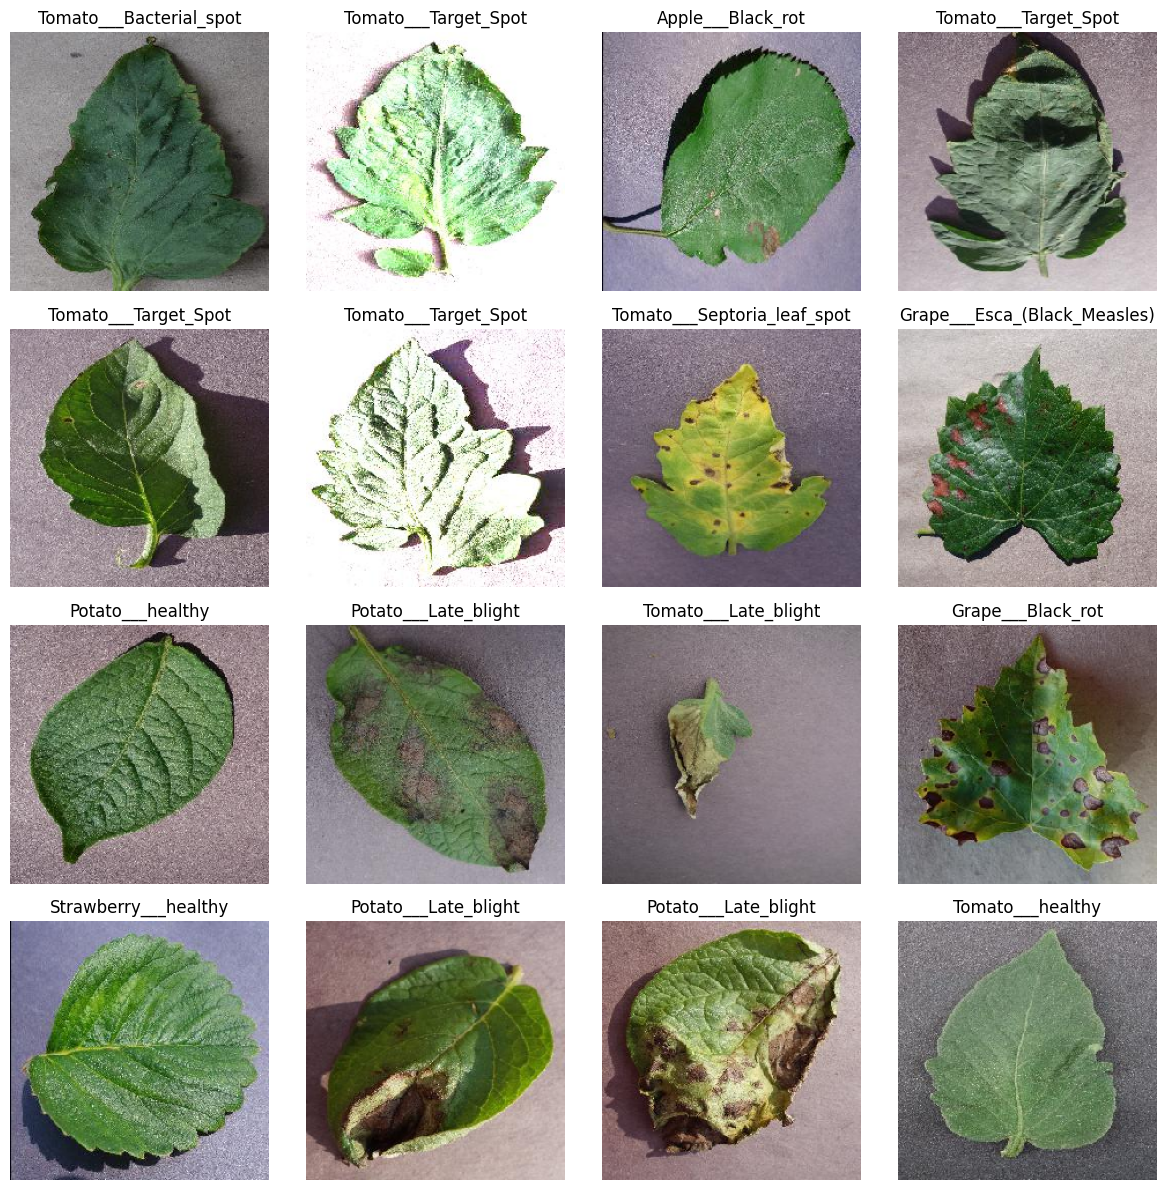

In [25]:
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])
    plt.axis("off")

plt.tight_layout()
plt.show()

## Modeling

Metrics functions

In [11]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

Prediction function

In [14]:
def predict_labels_and_display(model_path, test_dir=r'C:\Users\Farid Pashayev\Desktop\UFAZ\Master Project\Plant Diseases Detection\dataset\plant_leaf_dataset\test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## VGG16 Model

In [29]:
VGG_16 = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))

# iterate through its layers and frezzing them expect the last block (last 5 layers)
for layer in VGG_16.layers[:-5]:
    layer.trainable = False

In [33]:
# take the last layer from VGG16 and link it with my fully connected layer
last_output = VGG_16.output

x = GlobalAveragePooling2D()(last_output)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)


x = Dense(33, activation='softmax')(x)

VGG_16_model = Model(inputs=VGG_16.input, outputs=x)

VGG_16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
VGG_16_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,3

 Total params: 14,930,657 (56.96 MB)

 Trainable params: 7,295,265 (27.83 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [35]:
# train the model
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Plant_Disease/vgg_16_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

history =VGG_16_model.fit(train_data,
                        validation_data=valid_data,
                        epochs=10,
                        batch_size=64,
                        callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.2197 - loss: 2.7717
Epoch 1: val_accuracy improved from -inf to 0.83355, saving model to /content/drive/MyDrive/Plant_Disease/vgg_16_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 448s 546ms/step - accuracy: 0.2200 - loss: 2.7704 - val_accuracy: 0.8336 - val_loss: 0.5332
Epoch 2/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8556 - loss: 0.4745
Epoch 2: val_accuracy improved from 0.83355 to 0.91990, saving model to /content/drive/MyDrive/Plant_Disease/vgg_16_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 389s 507ms/step - accuracy: 0.8557 - loss: 0.4745 - val_accuracy: 0.9199 - val_loss: 0.2637
Epoch 3/10
762/762 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9329 - loss: 0.2183
Epoch 3: val_accuracy improved from 0.91990 to 0.94808, saving model to /content/drive/MyDrive/Plant_Disease/vgg_16_model.keras
762/762 ━━━━━━━━━━━━━━━━━━━━ 424s 484ms/step - accuracy: 0.9329 - loss: 0.2183 - val_accuracy: 0.9481 - val_loss:

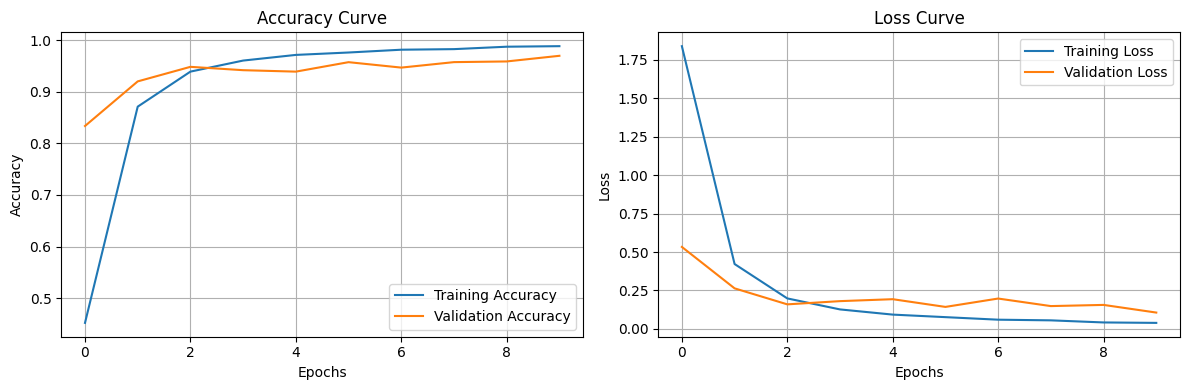

In [36]:
# show learning curves
plot_learning_curves(history)

In [37]:
# # save model to use later
VGG_16_model.save('/content/drive/MyDrive/Plant_Disease/Models/VGG_16_model.keras')

In [9]:
# showe accuracy on test data
best_model = load_model(r'C:\Users\Farid Pashayev\Desktop\UFAZ\Master Project\Plant Diseases Detection\VGG_16_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 2408s 10s/step - accuracy: 0.9699 - loss: 0.1044
Test Loss: 0.1032
Test Accuracy: 0.9706


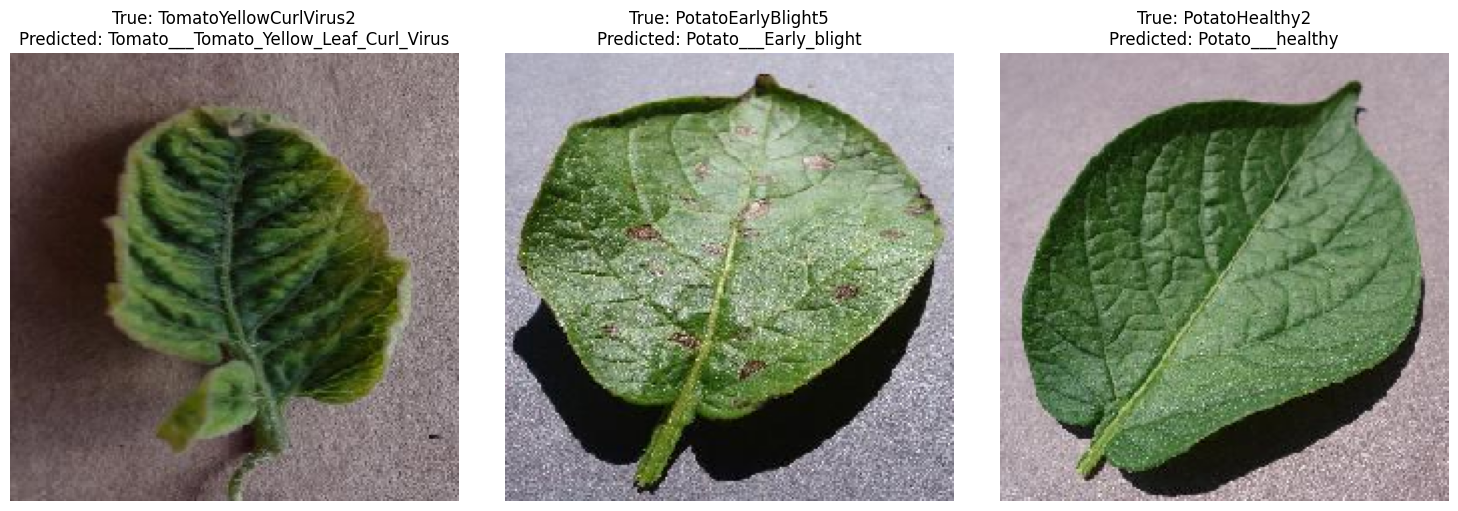

In [15]:
# show random sample of prediction of model on test data
predict_labels_and_display(r'C:\Users\Farid Pashayev\Desktop\UFAZ\Master Project\Plant Diseases Detection\VGG_16_model.keras')